In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import time
from tqdm import tqdm
import seaborn as sns
from IPython import display
import geopandas as gpd

In [2]:
ts1 = pd.read_csv(r'C:\Users\jesse.pisel\Downloads\TTL_Prod041018\timeseries\1to5ts.csv', index_col=[0])
ts2 = pd.read_csv(r'C:\Users\jesse.pisel\Downloads\TTL_Prod041018\timeseries\7to17ts.csv', index_col=[0])
ts3 = pd.read_csv(r'C:\Users\jesse.pisel\Downloads\TTL_Prod041018\timeseries\19to33ts.csv', index_col=[0])
ts4 = pd.read_csv(r'C:\Users\jesse.pisel\Downloads\TTL_Prod041018\timeseries\35to45ts.csv', index_col=[0])

In [3]:
bigTSoil = pd.concat([ts1, ts2, ts3, ts4], axis=1)

In [16]:
bigTSoil.head()

,105063,105075,105079,105081,105082,105084,105092,105106,105107,105085,...,3530317,3530323,3729563,3530398,3530244,3530243,3530292,3530293,3530294,3530175
1978-01-31,22.0,312.0,384.0,190.0,53.0,0.0,120.0,155.0,312.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1978-02-28,55.0,292.0,312.0,272.0,105.0,0.0,107.0,145.0,292.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1978-03-31,44.0,329.0,342.0,318.0,79.0,0.0,116.0,155.0,312.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1978-04-30,52.0,315.0,418.0,296.0,57.0,0.0,112.0,172.0,258.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1978-05-31,41.0,327.0,389.0,310.0,102.0,0.0,119.0,179.0,268.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [366]:
bigTSoil.columns[0]

'105063'

In [414]:
Q0=bigTSoil['3729093'].rolling(window=1, center=False).mean().dropna().values
Q=Q0[np.where(Q0>1)[0][0]:]
T=range(0,len(Q))

In [415]:
from scipy.optimize import curve_fit

In [416]:
def decline_curve(curve_type, q_i):
    if curve_type == "exponential":
        def exponential_decline(T, a):
            return q_i*np.exp(-a*T)
        return exponential_decline
    
    elif curve_type == "hyperbolic":
        def hyperbolic_decline(T, a_i, b):
            return q_i/np.power((1+b*a_i*T), 1./b)
        return hyperbolic_decline
    
    elif curve_type == "harmonic":
        def parabolic_decline(T, a_i):
            return q_i/(1+a_i*T)
        return parabolic_decline
    
    else:
        raise "I don't know this decline curve!"

def L2_norm(Q, Q_obs):
    return np.sum(np.power(np.subtract(Q, Q_obs), 2))

In [417]:
exp_decline = decline_curve("exponential", Q[np.where(Q>0)[0][0]])
hyp_decline = decline_curve("hyperbolic", Q[np.where(Q>0)[0][0]])
har_decline = decline_curve("harmonic", Q[np.where(Q>0)[0][0]])

popt_exp, pcov_exp = curve_fit(exp_decline, T, Q, method="trf")
popt_hyp, pcov_hyp = curve_fit(hyp_decline, T, Q, method="trf")
popt_har, pcov_har = curve_fit(har_decline, T, Q, method="trf")

print("L2 Norm of exponential decline: ", L2_norm(exp_decline(T, popt_exp[0]), Q))
print("L2 Norm of hyperbolic decline decline: ", L2_norm(hyp_decline(T, popt_hyp[0], popt_hyp[1]), Q))
print("L2 Norm of harmonic decline decline: ", L2_norm(har_decline(T, popt_har[0]), Q))

L2 Norm of exponential decline:  23121.258423671166
L2 Norm of hyperbolic decline decline:  18985.35489003022
L2 Norm of harmonic decline decline:  19144.286161750948


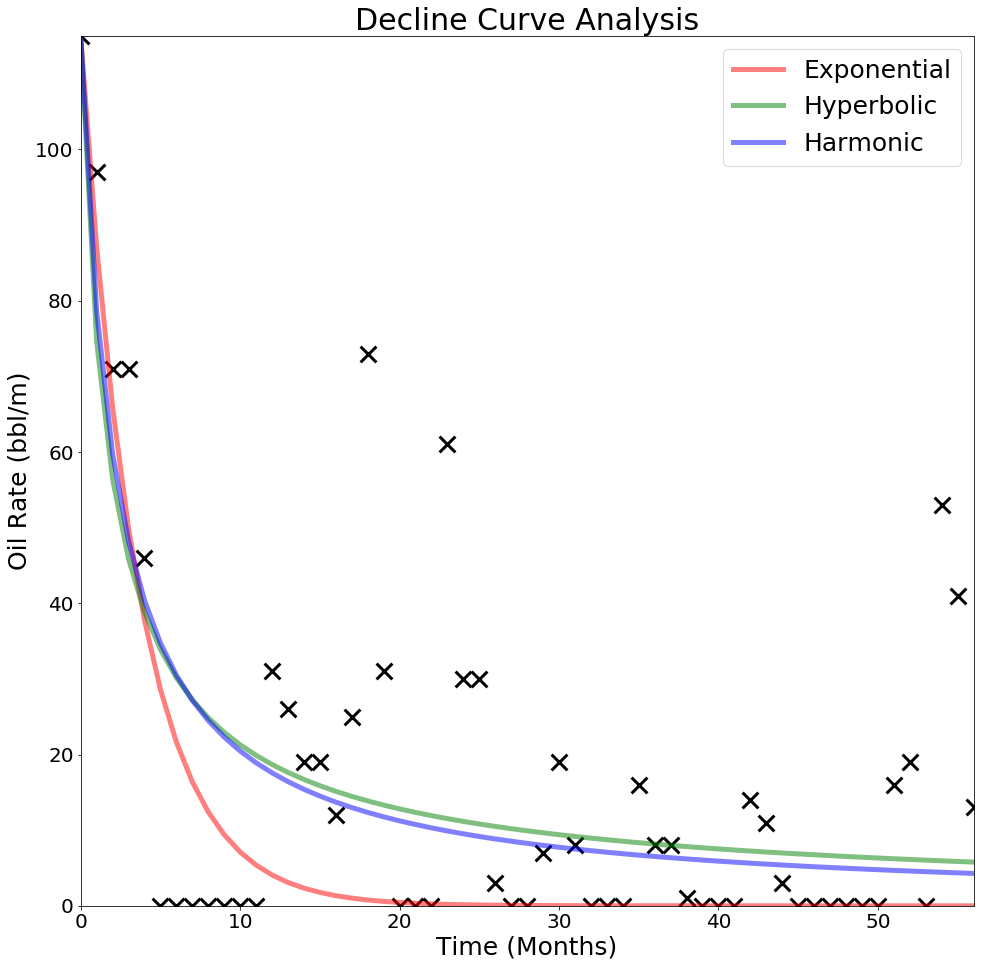

In [418]:
fig, ax = plt.subplots(1, figsize=(16, 16))

ax.set_title("Decline Curve Analysis", fontsize=30)

label_size = 20
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]

ax.set_xlim(min(T), max(T))

ax.scatter(T, Q, color="black", marker="x", s=250, linewidth=3)
ax.set_xlabel("Time (Months)", fontsize=25)
ax.set_ylabel("Oil Rate (bbl/m)", fontsize=25)

pred_exp = exp_decline(T, popt_exp[0])
pred_hyp = hyp_decline(T, popt_hyp[0], popt_hyp[1])
pred_har = har_decline(T, popt_har[0])

min_val = min([min(curve) for curve in [pred_exp, pred_hyp, pred_har]])
max_val = max([max(curve) for curve in [pred_exp, pred_hyp, pred_har]])

ax.set_ylim(min_val, max_val)

ax.plot(T, pred_exp, color="red", linewidth=5, alpha=0.5, label="Exponential")
ax.plot(T, pred_hyp, color="green", linewidth=5, alpha=0.5, label="Hyperbolic")
ax.plot(T, pred_har, color="blue", linewidth=5, alpha=0.5, label="Harmonic")
ax.ticklabel_format(fontsize=25)
ax.legend(fontsize=25)

C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':


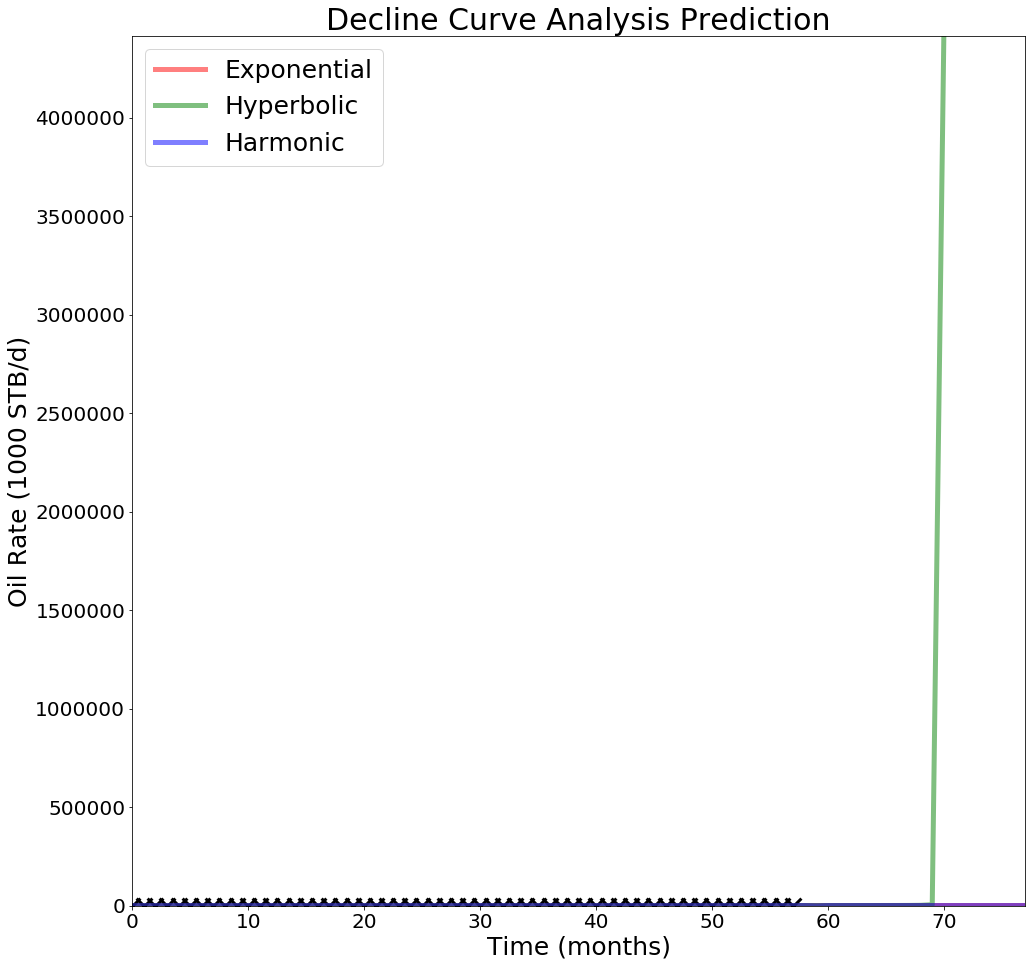

In [412]:
fig, ax = plt.subplots(1, figsize=(16, 16))

T_max = len(T)+20.0 #through January 2020
T_pred = np.arange(min(T), T_max)

ax.set_title("Decline Curve Analysis Prediction", fontsize=30)

label_size = 20
yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]

ax.set_xlim(min(T), max(T_pred))

ax.scatter(T, Q, color="black", marker="x", s=250, linewidth=3)
ax.set_xlabel("Time (months)", fontsize=25)
ax.set_ylabel("Oil Rate (1000 STB/d)", fontsize=25)

pred_exp = exp_decline(T_pred, popt_exp[0])
pred_hyp = hyp_decline(T_pred, popt_hyp[0], popt_hyp[1])
pred_har = har_decline(T_pred, popt_har[0])

min_val = min([min(curve) for curve in [pred_exp, pred_hyp, pred_har]])
max_val = max([max(curve) for curve in [pred_exp, pred_hyp, pred_har]])

ax.set_ylim(min_val, max_val)

ax.plot(T_pred, pred_exp, color="red", linewidth=5, alpha=0.5, label="Exponential")
ax.plot(T_pred, pred_hyp, color="green", linewidth=5, alpha=0.5, label="Hyperbolic")
ax.plot(T_pred, pred_har, color="blue", linewidth=5, alpha=0.5, label="Harmonic")
ax.ticklabel_format(fontsize=25)
ax.legend(fontsize=25)

In [354]:
len(T)+20

24

In [355]:
T_pred

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [356]:
504-(504-np.where(Q0>0)[0][0])

480

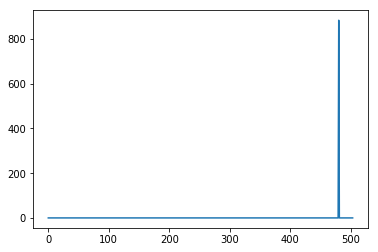

In [357]:
plt.plot(np.pad(pred_hyp, (504-(504-np.where(Q0>0)[0][0]),0),'constant'))

In [ ]:
df = pd.DataFrame(index=pd.date_range('1978-01-31', '2019-12-31', freq='M'))
for i in tqdm(range(76953)):
    try:
        Q0=bigTSoil.iloc[0:,i].rolling(window=1, center=False).mean().dropna().values
        Q=Q0[np.where(Q0>10)[0][0]:]
        T=range(0,len(Q))
        hyp_decline = decline_curve("hyperbolic", Q[np.where(Q>0)[0][0]])
        popt_hyp, pcov_hyp = curve_fit(hyp_decline, T, Q, method="trf")
    
        T_max = len(T)+20.0 #through January 2020
        T_pred = np.arange(min(T), T_max)
        pred_hyp = hyp_decline(T_pred, popt_hyp[0], popt_hyp[1])
        filled = np.pad(pred_hyp, (504-(504-np.where(Q0>0)[0][0]),0),'constant')
        df[bigTSoil.columns[i]] = filled
    except:
        pass

  0%|                                                                                        | 0/76953 [00:00<?, ?it/s]C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
  0%|                                                                                | 5/76953 [00:00<26:41, 48.04it/s]C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
  0%|                                                                               | 54/76953 [00:01<33:23, 38.38it/s]C:\Users\jesse.pisel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':
  1%|▍                                                                             | 455/

In [ ]:
df.plot(legend=False)

In [404]:
df.max()[df.max()>100000]

930323     4.607719e+05
3720341    1.320120e+05
4120169    1.033530e+05
3729093    4.413968e+06
dtype: float64

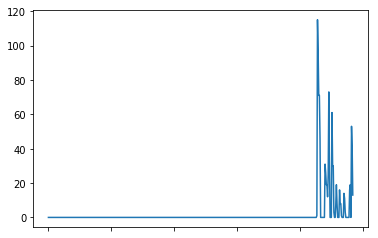

In [406]:
bigTSoil['3729093'].plot()

In [413]:
Q

array([  1., 115.,  97.,  71.,  71.,  46.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,  31.,  26.,  19.,  19.,  12.,  25.,  73.,  31.,   0.,
         0.,   0.,  61.,  30.,  30.,   3.,   0.,   0.,   7.,  19.,   8.,
         0.,   0.,   0.,  16.,   8.,   8.,   1.,   0.,   0.,   0.,  14.,
        11.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,  16.,  19.,   0.,
        53.,  41.,  13.])